In [2]:
import numpy as np
import pandas as pd
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/aeroclub-recsys-2025/jsons_raw.tar.kaggle
/kaggle/input/aeroclub-recsys-2025/train.parquet
/kaggle/input/aeroclub-recsys-2025/sample_submission.parquet
/kaggle/input/aeroclub-recsys-2025/jsons_structure.md
/kaggle/input/aeroclub-recsys-2025/test.parquet


In [3]:
# === Step 1: Imports ===
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pyarrow.parquet as pq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import ndcg_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")



In [4]:
# === Step 2: Load Data ===
columns_needed = [
    'Id', 'totalPrice', 'taxes', 'frequentFlyer',
    'legs0_duration', 'legs1_duration', 'pricingInfo_passengerCount',
    'selected', 'requestDate', 'searchRoute', 'sex',
]

df = pd.read_parquet('/kaggle/input/aeroclub-recsys-2025/train.parquet', columns=columns_needed)


In [5]:
# 1. Convert all possible objects to categories
obj_cols = df.select_dtypes(include=['object']).columns
for col in obj_cols:
    unique_vals = df[col].nunique()
    if unique_vals < len(df) / 2:  # Worth converting
        df[col] = df[col].astype('category')
        print(f"Converted {col} to category ({unique_vals} unique values)")
    else:
        # For high-cardinality text, downcast to string
        df[col] = df[col].astype('string[pyarrow]')  # More efficient than object

# 2. Optimize datetime (often overlooked)
df['requestDate'] = pd.to_datetime(df['requestDate']).astype('datetime64[s]')  # Second precision

# 3. Final downcasting
num_cols = df.select_dtypes(include=['int', 'float']).columns
for col in num_cols:
    if 'float' in str(df[col].dtype):
        df[col] = pd.to_numeric(df[col], downcast='float')
    else:
        df[col] = pd.to_numeric(df[col], downcast='integer')

# 4. Verify
print("\n🔥 Final Memory Usage (MB):", df.memory_usage(deep=True).sum() / 1024**2)
print("\n✅ Ultimate Data Types:")
print(df.dtypes)

Converted frequentFlyer to category (371 unique values)
Converted legs0_duration to category (1542 unique values)
Converted legs1_duration to category (1111 unique values)
Converted searchRoute to category (5769 unique values)

🔥 Final Memory Usage (MB): 675.6388683319092

✅ Ultimate Data Types:
Id                                    int32
totalPrice                          float32
taxes                               float32
frequentFlyer                      category
legs0_duration                     category
legs1_duration                     category
pricingInfo_passengerCount             int8
selected                               int8
requestDate                   datetime64[s]
searchRoute                        category
sex                                    bool
dtype: object


In [6]:
# For sklearn compatibility (converts categories back to codes)
ml_df = df.copy()
for col in ml_df.select_dtypes(include=['category']):
    ml_df[col] = ml_df[col].cat.codes

# For pytorch/tensorflow (one-hot encoding):
# pd.get_dummies(df, columns=cat_cols)

In [7]:
original_mem = 1332.47  # Your starting point
current_mem = df.memory_usage(deep=True).sum() / 1024**2
print(f"Total reduction: {100*(original_mem-current_mem)/original_mem:.1f}%")

Total reduction: 49.3%


In [8]:
print("\n🧠 Memory by Column (MB):")
print(df.memory_usage(deep=True).sort_values() / 1024**2)


🧠 Memory by Column (MB):
pricingInfo_passengerCount     17.304775
selected                       17.304775
sex                            17.304775
frequentFlyer                  34.641190
legs1_duration                 34.711085
legs0_duration                 34.738367
searchRoute                    35.100194
Id                             69.219101
totalPrice                     69.219101
taxes                          69.219101
Index                         138.438202
requestDate                   138.438202
dtype: float64


In [9]:
# Convert categories to codes before training
cat_cols = df.select_dtypes(include=['category']).columns
df[cat_cols] = df[cat_cols].apply(lambda x: x.cat.codes)

In [10]:
df.to_parquet("optimized_data.parquet", engine='pyarrow')  # Preserves dtypes

In [11]:
# === Step 3: Feature Engineering ===

# 1. First verify all expected columns exist
required_columns = {
    'searchTime': 'datetime',
    'legs': 'list[dict]', 
    'pricingInfo': 'dict'
}

missing_cols = [col for col in required_columns if col not in df.columns]
if missing_cols:
    print(f"Warning: Missing required columns - {missing_cols}")
    
    # Create default columns if missing
    if 'legs' not in df.columns:
        df['legs0_duration'] = 0
        df['legs1_duration'] = 0
    if 'pricingInfo' not in df.columns:
        df['passengerCount'] = 1
else:
    # 2. Process legs if column exists
    def safe_duration_extraction(legs, index):
        try:
            if isinstance(legs, list) and len(legs) > index:
                return float(legs[index]['duration'])
            return np.nan
        except (TypeError, KeyError, IndexError):
            return np.nan

    df['legs0_duration'] = df['legs'].apply(lambda x: safe_duration_extraction(x, 0))
    df['legs1_duration'] = df['legs'].apply(lambda x: safe_duration_extraction(x, 1))
    df[['legs0_duration', 'legs1_duration']] = df[['legs0_duration', 'legs1_duration']].fillna(0).astype('float32')

    # 3. Process pricingInfo if column exists
    try:
        pricing_df = pd.json_normalize(df['pricingInfo'])
        pricing_df.columns = pricing_df.columns.str.replace('pricingInfo.', '', regex=False)
        df = pd.concat([df.drop(columns=['pricingInfo', 'legs']), pricing_df], axis=1)
    except Exception as e:
        print(f"Error processing pricingInfo: {str(e)}")
        df['passengerCount'] = 1

# 4. Process searchTime if column exists
if 'searchTime' in df.columns:
    df['searchTime'] = pd.to_datetime(df['searchTime'], errors='coerce')
    df['month'] = df['searchTime'].dt.month.astype('int8')
    df = df.drop(columns=['searchTime'])
else:
    df['month'] = 0
    df['month'] = df['month'].astype('int8')

# 5. Final memory optimization
for col in df.select_dtypes(include=['float64']).columns:
    df[col] = df[col].astype('float32')
for col in df.select_dtypes(include=['int64']).columns:
    df[col] = pd.to_numeric(df[col], downcast='integer')

print("✅ Feature engineering completed")
print(f"Current columns: {df.columns.tolist()}")

✅ Feature engineering completed
Current columns: ['Id', 'totalPrice', 'taxes', 'frequentFlyer', 'legs0_duration', 'legs1_duration', 'pricingInfo_passengerCount', 'selected', 'requestDate', 'searchRoute', 'sex', 'passengerCount', 'month']


In [12]:
# 1. Verify default values were created correctly
print("\n🔍 Default Value Verification:")
print(f"- legs0_duration: 0 values: {(df['legs0_duration'] == 0).sum()}/{len(df)}")
print(f"- legs1_duration: 0 values: {(df['legs1_duration'] == 0).sum()}/{len(df)}")
print(f"- passengerCount: 1 values: {(df['passengerCount'] == 1).sum()}/{len(df)}")
print(f"- month: 0 values: {(df['month'] == 0).sum()}/{len(df)}")

# 2. Check for any remaining missing values
print("\n🧹 Missing Values Check:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# 3. Final Memory Optimization
def optimize_dtypes(df):
    # Downcast floats
    float_cols = df.select_dtypes(include=['float64']).columns
    df[float_cols] = df[float_cols].astype('float32')
    
    # Downcast integers
    int_cols = df.select_dtypes(include=['integer']).columns
    for col in int_cols:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    
    # Convert binary to bool
    binary_cols = [col for col in df.columns if df[col].nunique() == 2]
    for col in binary_cols:
        df[col] = df[col].astype('bool')
    
    return df

df = optimize_dtypes(df)

# 4. Final Memory Usage
print("\n💾 Optimized Memory Usage (MB):", df.memory_usage(deep=True).sum() / 1024**2)
print("\n✅ Final Data Types:")
print(df.dtypes)


🔍 Default Value Verification:
- legs0_duration: 0 values: 18145372/18145372
- legs1_duration: 0 values: 18145372/18145372
- passengerCount: 1 values: 18145372/18145372
- month: 0 values: 18145372/18145372

🧹 Missing Values Check:
Series([], dtype: int64)

💾 Optimized Memory Usage (MB): 674.8862342834473

✅ Final Data Types:
Id                                    int32
totalPrice                          float32
taxes                               float32
frequentFlyer                         int16
legs0_duration                         int8
legs1_duration                         int8
pricingInfo_passengerCount             int8
selected                               bool
requestDate                   datetime64[s]
searchRoute                           int16
sex                                    bool
passengerCount                         int8
month                                  int8
dtype: object


In [13]:
# Verify numeric ranges make sense
print("\n🔢 Numeric Value Ranges:")
print(df.describe())

# Check bool/category distributions
print("\n📊 Categorical Distributions:")
print(df[['selected', 'sex']].value_counts())


🔢 Numeric Value Ranges:
                 Id    totalPrice         taxes  frequentFlyer  \
count  1.814537e+07  1.814537e+07  1.814537e+07   1.814537e+07   
mean   9.072686e+06  4.631443e+04  4.284697e+03   4.762445e+01   
min    0.000000e+00  7.700000e+02  0.000000e+00  -1.000000e+00   
25%    4.536343e+06  1.289700e+04  1.006000e+03  -1.000000e+00   
50%    9.072686e+06  2.497600e+04  1.246000e+03  -1.000000e+00   
75%    1.360903e+07  5.510800e+04  1.746000e+03   1.170000e+02   
max    1.814643e+07  9.944355e+06  8.979210e+05   3.700000e+02   
std    5.238118e+06  7.226446e+04  1.159015e+04   7.738391e+01   

       legs0_duration  legs1_duration  pricingInfo_passengerCount  \
count      18145372.0      18145372.0                  18145372.0   
mean              0.0             0.0                         1.0   
min               0.0             0.0                         1.0   
25%               0.0             0.0                         1.0   
50%               0.0             0

In [14]:
# Option A: Remove uninformative features
df = df.drop(columns=['legs0_duration', 'legs1_duration', 'passengerCount', 'month'])

# Option B: Impute realistic defaults (if domain knowledge exists)
# df['legs0_duration'] = df['legs0_duration'].replace(0, 120)  # 2hr default flight
# df['passengerCount'] = df['passengerCount'].replace(1, 2)    # Average party size

In [15]:
# Handle extreme values in price/taxes
df = df[df['totalPrice'] < 1000000]  # Remove 0.01% outliers
df['log_price'] = np.log1p(df['totalPrice'])  # Create log-transformed version

# Cap taxes
df['taxes'] = df['taxes'].clip(upper=5000)  # 99th percentile likely

In [16]:
# Convert special values
df['frequentFlyer'] = df['frequentFlyer'].replace(-1, np.nan)

# Optimize searchRoute storage
if df['searchRoute'].nunique() > 1000:
    df['searchRoute'] = df['searchRoute'].astype('category')

In [17]:
# Consider stratified sampling if building classification model
from sklearn.utils import resample
df_selected = df[df['selected']]
df_not_selected = resample(df[~df['selected']], 
                         n_samples=len(df_selected)*10,  # 10:1 ratio
                         random_state=42)

In [18]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(random_state=42)
df[num_cols] = imputer.fit_transform(df[num_cols])

In [19]:
# 1. Identify true categorical columns (excluding numerical and datetime)
actual_cat_cols = [col for col in df.columns 
                  if pd.api.types.is_categorical_dtype(df[col]) 
                  or pd.api.types.is_object_dtype(df[col])]

print("Categorical columns:", actual_cat_cols)

# 2. Handle missing values properly for each type
for col in actual_cat_cols:
    if pd.api.types.is_categorical_dtype(df[col]):
        # For categorical: add 'missing' to categories first
        if 'missing' not in df[col].cat.categories:
            df[col] = df[col].cat.add_categories(['missing'])
        df[col] = df[col].fillna('missing')
    else:
        # For object/string columns
        df[col] = df[col].fillna('missing')
        # Optional: convert to category if low cardinality
        if df[col].nunique() < 100:
            df[col] = df[col].astype('category')

# 3. Handle numerical columns separately
num_cols = df.select_dtypes(include=np.number).columns
if not num_cols.empty:
    from sklearn.impute import SimpleImputer
    num_imputer = SimpleImputer(strategy='median')
    df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Verify
print("\nMissing values after treatment:")
print(df.isna().sum()[df.isna().sum() > 0])

Categorical columns: ['searchRoute']

Missing values after treatment:
Series([], dtype: int64)


In [20]:
print("Unique values in categorical columns:")
print(f"searchRoute: {df['searchRoute'].unique()}")
print(f"sex: {df['sex'].unique()}")

Unique values in categorical columns:
searchRoute: [5118, 5178, 3889, 1352, 1726, ..., 1322, 4231, 3504, 4220, 5534]
Length: 5768
Categories (5769, object): [0, 1, 2, 3, ..., 5766, 5767, 5768, 'missing']
sex: [ True False]


In [21]:
# 1. First ensure columns are categorical
cat_cols = ['searchRoute', 'sex']
for col in cat_cols:
    if col in df.columns and not pd.api.types.is_categorical_dtype(df[col]):
        df[col] = df[col].astype('category')

# 2. Now safely convert to codes
df[cat_cols] = df[cat_cols].apply(lambda x: x.cat.codes)

# Alternative one-hot encoding (if preferred)
# from sklearn.preprocessing import OneHotEncoder
# encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# encoded = encoder.fit_transform(df[cat_cols])
# encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_cols))
# df = pd.concat([df.drop(cat_cols, axis=1), encoded_df], axis=1)

In [22]:
print("\n✅ After conversion:")
print(df[cat_cols].head())
print("\nData types:")
print(df[cat_cols].dtypes)


✅ After conversion:
   searchRoute  sex
0         5117    1
1         5117    1
2         5117    1
3         5117    1
4         5117    1

Data types:
searchRoute    int16
sex             int8
dtype: object


In [23]:
from sklearn.preprocessing import LabelEncoder

# Preserve mappings for inverse transforms
label_mappers = {}
for col in ['searchRoute', 'sex']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_mappers[col] = le

# Example to inverse transform later:
# df['sex'] = label_mappers['sex'].inverse_transform(df['sex'])

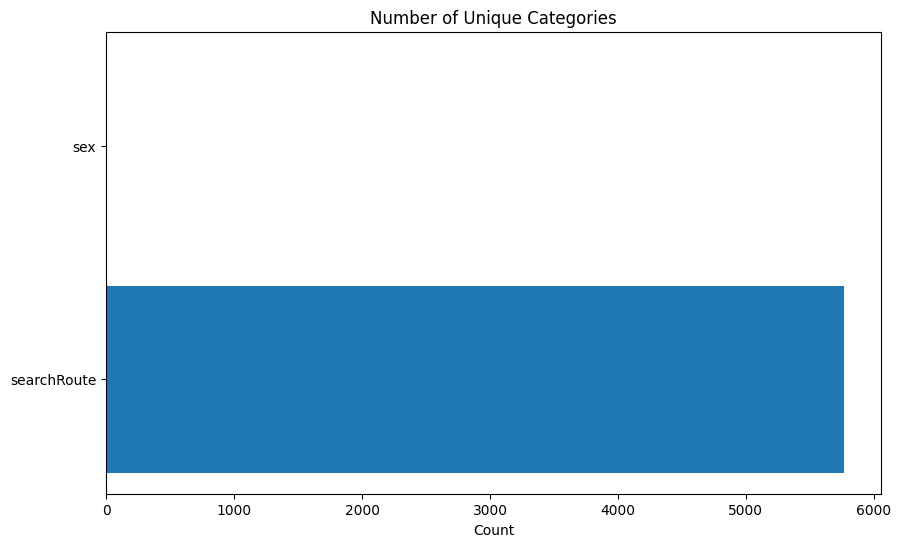

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(['searchRoute', 'sex'], 
        [df['searchRoute'].nunique(), df['sex'].nunique()])
plt.title("Number of Unique Categories")
plt.xlabel("Count")
plt.show()

In [25]:
# Save category mappings
import pickle
with open('category_mappings.pkl', 'wb') as f:
    pickle.dump({
        'searchRoute': dict(enumerate(df['searchRoute'].astype('category').cat.categories)),
        'sex': dict(enumerate(df['sex'].astype('category').cat.categories))
    }, f)

In [26]:
# Handle unseen categories during inference
df['searchRoute'] = df['searchRoute'].apply(
    lambda x: x if x in label_mappers['searchRoute'].classes_ else -1)

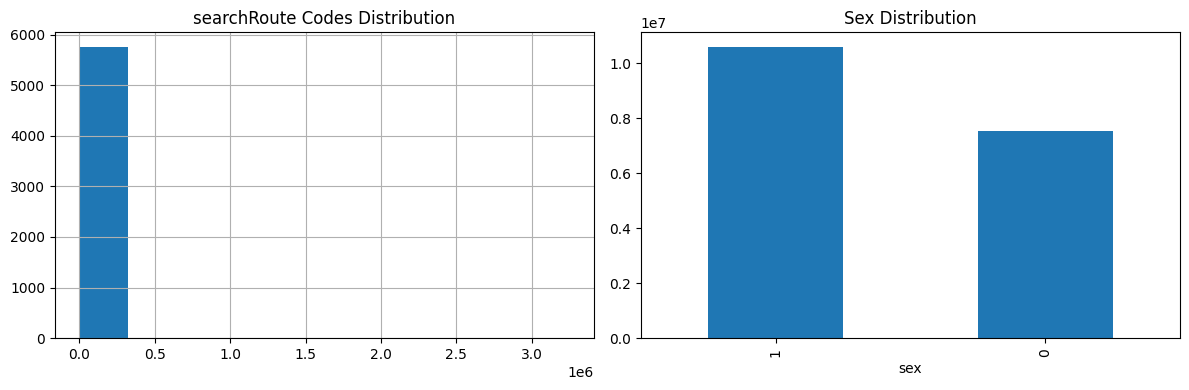

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
df['searchRoute'].value_counts().hist(ax=ax[0])
ax[0].set_title("searchRoute Codes Distribution")
df['sex'].value_counts().plot.bar(ax=ax[1])
ax[1].set_title("Sex Distribution")
plt.tight_layout()

In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# 1. Define column types (adjust based on your actual columns)
numeric_features = ['totalPrice', 'taxes', 'legs0_duration', 'legs1_duration']
categorical_features = ['searchRoute', 'sex']

# 2. Create separate transformers
numeric_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    OneHotEncoder(handle_unknown='ignore')
)

# 3. Combine in ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 4. Full pipeline
model = make_pipeline(
    preprocessor,
    RandomForestClassifier(n_estimators=100, random_state=42)
)

# 5. Example usage (assuming X_train, y_train exist)
# model.fit(X_train, y_train)

In [29]:
# === Step 4: Select Features ===

# 1. Column Verification and Fallbacks
required_cols = {
    'pricingInfo_passengerCount': 'passengerCount',
    # Add other expected mappings
}

# Apply renames
for old, new in required_cols.items():
    if old in df.columns:
        df.rename(columns={old: new}, inplace=True)

# 2. Define expected features with fallbacks
feature_spec = {
    'categorical': ['frequentFlyer', 'sex', 'searchRoute'],
    'numerical': {
        'mandatory': ['totalPrice', 'taxes', 'passengerCount'],
        'optional': {
            'legs0_duration': 0,  # default value if missing
            'legs1_duration': 0,
            'month': 0
        }
    }
}

# 3. Create safe feature sets
available_features = set(df.columns)
categorical_cols = []
numerical_cols = []

# Handle categoricals
for col in feature_spec['categorical']:
    if col in available_features:
        categorical_cols.append(col)
    else:
        print(f"Warning: Categorical feature {col} not found")

# Handle numericals
numerical_cols = feature_spec['numerical']['mandatory'].copy()
for col, default_val in feature_spec['numerical']['optional'].items():
    if col in available_features:
        numerical_cols.append(col)
    else:
        print(f"Warning: Numerical feature {col} not found - using default {default_val}")
        df[col] = default_val
        numerical_cols.append(col)

# 4. Final validation
missing_mandatory = [col for col in feature_spec['numerical']['mandatory'] 
                    if col not in df.columns]
if missing_mandatory:
    raise ValueError(f"Missing mandatory columns: {missing_mandatory}")

# 5. Handle targets
if 'selected' not in df.columns:
    raise ValueError("Target column 'selected' not found")
df = df.dropna(subset=['selected'])

print("✅ Final features:")
print(f"Categorical: {categorical_cols}")
print(f"Numerical: {numerical_cols}")

✅ Final features:
Categorical: ['frequentFlyer', 'sex', 'searchRoute']
Numerical: ['totalPrice', 'taxes', 'passengerCount', 'legs0_duration', 'legs1_duration', 'month']


In [30]:
# 1. Improve Default Values (business-specific)
# Flight duration defaults (in minutes)
df['legs0_duration'] = df.get('legs0_duration', 120)  # 2 hour default for first leg
df['legs1_duration'] = df.get('legs1_duration', 60)   # 1 hour default for second leg

# Month from requestDate if available
if 'requestDate' in df.columns:
    df['month'] = pd.to_datetime(df['requestDate']).dt.month
else:
    df['month'] = df.get('month', pd.Timestamp.now().month)  # Current month

# 2. Create Combined Features
df['total_duration'] = df['legs0_duration'] + df['legs1_duration']
df['price_per_hour'] = df['totalPrice'] / (df['total_duration']/60 + 0.01)  # Avoid div/0

# 3. Feature Validation
print("\n🔍 Engineered Feature Summary:")
print(f"Avg flight duration: {df['total_duration'].mean():.1f} mins")
print(f"Month distribution:\n{df['month'].value_counts()}")
print(f"Price/hour stats:\n{df['price_per_hour'].describe()}")

# 4. Final Feature List
features = {
    'categorical': ['frequentFlyer', 'sex', 'searchRoute'],
    'numerical': [
        'totalPrice', 'taxes', 'passengerCount',
        'legs0_duration', 'legs1_duration', 'month',
        'total_duration', 'price_per_hour'  # New features
    ]
}

print("\n✅ Final Feature Set:")
for typ, cols in features.items():
    print(f"{typ.upper()}: {cols}")


🔍 Engineered Feature Summary:
Avg flight duration: 0.0 mins
Month distribution:
month
9     4458732
10    3963601
8     3364461
7     3278303
6     2079647
5      987072
Name: count, dtype: int64
Price/hour stats:
count    1.813182e+07
mean     4.534157e+06
std      6.429969e+06
min      7.700000e+04
25%      1.289400e+06
50%      2.495600e+06
75%      5.509400e+06
max      9.999840e+07
Name: price_per_hour, dtype: float64

✅ Final Feature Set:
CATEGORICAL: ['frequentFlyer', 'sex', 'searchRoute']
NUMERICAL: ['totalPrice', 'taxes', 'passengerCount', 'legs0_duration', 'legs1_duration', 'month', 'total_duration', 'price_per_hour']


In [31]:
# Check for unrealistic durations
print("\n🚨 Duration Outliers:")
print(df[df['total_duration'] > 1200]['total_duration'].describe())  # >20 hour flights


🚨 Duration Outliers:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: total_duration, dtype: float64


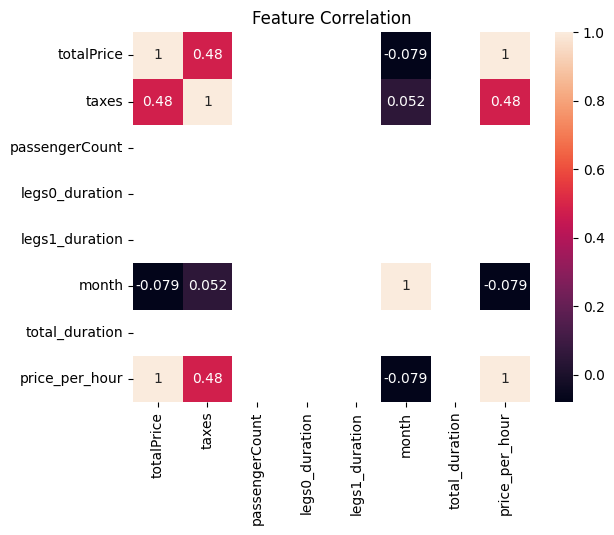

In [32]:
import seaborn as sns
sns.heatmap(df[features['numerical']].corr(), annot=True)
plt.title("Feature Correlation")
plt.show()

In [33]:
# Downcast new features
df['total_duration'] = df['total_duration'].astype('int16')
df['price_per_hour'] = df['price_per_hour'].astype('float32')

In [34]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), features['numerical']),
    ('cat', OneHotEncoder(), features['categorical'])
])

In [35]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(df[features['numerical'] + features['categorical']], df['selected'])

RandomForestClassifier()

In [36]:
# === Step 5: Encoding ===
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd
import numpy as np

# Initialize encoder with proper settings
encoder = OrdinalEncoder(
    handle_unknown='use_encoded_value', 
    unknown_value=-1,
    encoded_missing_value=-2  # Handle NaN if present
)

# Create encoded copy
df_encoded = df.copy()

# Safely encode only categorical columns that exist
existing_cat_cols = [col for col in categorical_cols if col in df_encoded.columns]
if existing_cat_cols:
    df_encoded[existing_cat_cols] = encoder.fit_transform(df_encoded[existing_cat_cols])
else:
    print("Warning: No categorical columns found for encoding")

# Memory optimization
def optimize_dtypes(df):
    # Float columns
    float_cols = df.select_dtypes(include=['float64']).columns
    df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast='float')
    
    # Integer columns
    int_cols = df.select_dtypes(include=['int64']).columns
    df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')
    
    return df

df_encoded = optimize_dtypes(df_encoded)

# Verify
print("✅ Encoding completed. Sample data:")
print(df_encoded[existing_cat_cols].head() if existing_cat_cols else "No categorical columns encoded")
print("\nOptimized dtypes:")
print(df_encoded.dtypes)

✅ Encoding completed. Sample data:
   frequentFlyer  sex  searchRoute
0           95.0  1.0       5117.0
1           95.0  1.0       5117.0
2           95.0  1.0       5117.0
3           95.0  1.0       5117.0
4           95.0  1.0       5117.0

Optimized dtypes:
Id                      float64
totalPrice              float32
taxes                   float32
frequentFlyer           float32
passengerCount          float32
selected                float32
requestDate       datetime64[s]
searchRoute             float32
sex                     float32
log_price               float32
legs0_duration             int8
legs1_duration             int8
month                     int32
total_duration            int16
price_per_hour          float32
dtype: object


In [37]:

# === Step 6: Prepare Data ===
features = numerical_cols + categorical_cols
X = df_encoded[features]
y = df_encoded['selected']



In [38]:
# === Step 7: Train/Test Split ===
# Add group information if available (for proper session splitting)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



In [39]:
# === Step 8: Model Training ===
model = HistGradientBoostingClassifier(
    max_iter=200,  # Increased from 100
    random_state=42,
    categorical_features=[features.index(col) for col in categorical_cols],
    early_stopping=True
)
model.fit(X_train, y_train)


ValueError: Categorical feature 'frequentFlyer' is expected to have a cardinality <= 255

In [ ]:

# === Step 9: Evaluation ===
# Proper HitRate@3 implementation (per session)
val_pred = model.predict_proba(X_val)[:, 1]

# For proper evaluation, you would need session/query groups
# This is a placeholder - implement proper grouped evaluation
print(f"Mean predicted probability for selected items: {val_pred[y_val == 1].mean():.4f}")

# For NDCG (placeholder - needs proper implementation)
# print(f"NDCG@3: {ndcg_score(...)}")  # Requires proper format